In [1]:
# Logger
import logging
logging.basicConfig(level=logging.WARN)

# Enable automatic module reload
%load_ext autoreload
%autoreload 2

# Load PyALCS ACSM module
from bacs.agents.bacs import BACS, Configuration
from bacs.agents.bacs.utils.GymMazeWrapper import _maze_metrics, parse_metrics_to_df, plot_performance

# Load environments
import gym
import my_mazes

## Agent - BACS

### Common parameters

In [2]:
CLASSIFIER_LENGTH = 8
NUMBER_OF_POSSIBLE_ACTIONS = 8

MAZE = "Woods100-v0"

NUMBER_OF_EXPLORE_TRIALS = 300
DO_ACTION_PLANNING_EXPLORE = False
DO_GA_EXPLORE = False
DO_SUBSUMPTION_EXPLORE = True
BETA_EXPLORE = 0.05
EPSILON = 0.8

NUMBER_OF_EXPLOIT_TRIALS = 500
DO_ACTION_PLANNING_EXPLOIT = False
DO_SUBSUMPTION_EXPLOIT = True
BETA_EXPLOIT = 0.00

LENGTH_OF_BEHAVIORAL_SEQUENCES = 0

### Environment - Maze

In [3]:
# Initialize environment
maze = gym.make(MAZE)
# Reset it, by putting an agent into random position
situation = maze.reset()
# Render the state in ASCII
maze.render()


■ ■ ■ ■ ■ ■ ■ ■ ■
■ A □ □ $ □ □ □ ■
■ ■ ■ ■ ■ ■ ■ ■ ■


### Training of BACS - Exploration

In [4]:
%%time

cfg_explore = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    do_ga=DO_GA_EXPLORE,
    do_subsumption=DO_SUBSUMPTION_EXPLORE,
    do_action_planning=DO_ACTION_PLANNING_EXPLORE,
    action_planning_frequency=50,
    beta=BETA_EXPLORE,
    gamma=0.95,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=EPSILON,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_as=20,
    mu=0.3,
    chi=0.8,
    bs_max=LENGTH_OF_BEHAVIORAL_SEQUENCES
)

agent_explore = BACS(cfg_explore)
population_explore, metrics_explore = agent_explore.explore(maze, NUMBER_OF_EXPLORE_TRIALS)

CPU times: user 1.91 s, sys: 10.3 ms, total: 1.92 s
Wall time: 1.95 s


In [5]:
population_explore_to_display = [cl for cl in population_explore if cl.does_anticipate_change()]
for cl in population_explore_to_display:
    print(cl)
    #print("{!r} \t {!r} \t {!r} \t {:.3f} \t {:.3f} \t {:.1f} \t {!r} \t {!r}".format(cl.condition, cl.action, cl.effect, cl.fitness, cl.q, cl.talp, cl.exp, cl.mark))
    print("\n")

##1##### 6 None None ##0#####         (empty)               q: 1.0   r: 379.3  ir: 0.0    f: 379.3  exp: 363 tga: 39    talp: 4829  tav: 12.2   num: 1


######9# 6 None None ######0#         (empty)               q: 1.0   r: 999.7  ir: 999.7  f: 999.6  exp: 158 tga: 40    talp: 4831  tav: 38.7   num: 1


##0###0# 6 None None ######9#         (11#111#1)            q: 0.64  r: 740.3  ir: 0.0    f: 473.8  exp: 444 tga: 63    talp: 4830  tav: 13.5   num: 1


######9# 2 None None ######0#         (empty)               q: 1.0   r: 401.2  ir: 0.0    f: 401.2  exp: 155 tga: 69    talp: 4812  tav: 35.5   num: 1


##9##### 6 None None ##0#####         (empty)               q: 1.0   r: 386.6  ir: 0.0    f: 386.5  exp: 134 tga: 79    talp: 4752  tav: 32.9   num: 1


######1# 2 None None ######0#         (empty)               q: 1.0   r: 377.4  ir: 0.0    f: 377.4  exp: 238 tga: 83    talp: 4747  tav: 21.2   num: 1


##0###0# 2 None None ##9#####         (11#111#1)            q: 0.329 r: 553.0  ir:

### Exploitation of BACS

In [6]:
%%time

cfg_exploit = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    do_ga=False,
    do_subsumption=DO_SUBSUMPTION_EXPLOIT,
    do_action_planning=DO_ACTION_PLANNING_EXPLOIT,
    action_planning_frequency=50,
    beta=BETA_EXPLOIT,
    gamma=0.95,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=0.0,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_as=20,
    mu=0.3,
    chi=0.8,
    bs_max=1
)

agent_exploit = BACS(cfg_exploit, population_explore)
agent_exploit.clean_population()
population_exploit, metrics_exploit = agent_exploit.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS)

CPU times: user 2.72 s, sys: 12.5 ms, total: 2.74 s
Wall time: 2.76 s


### Performance

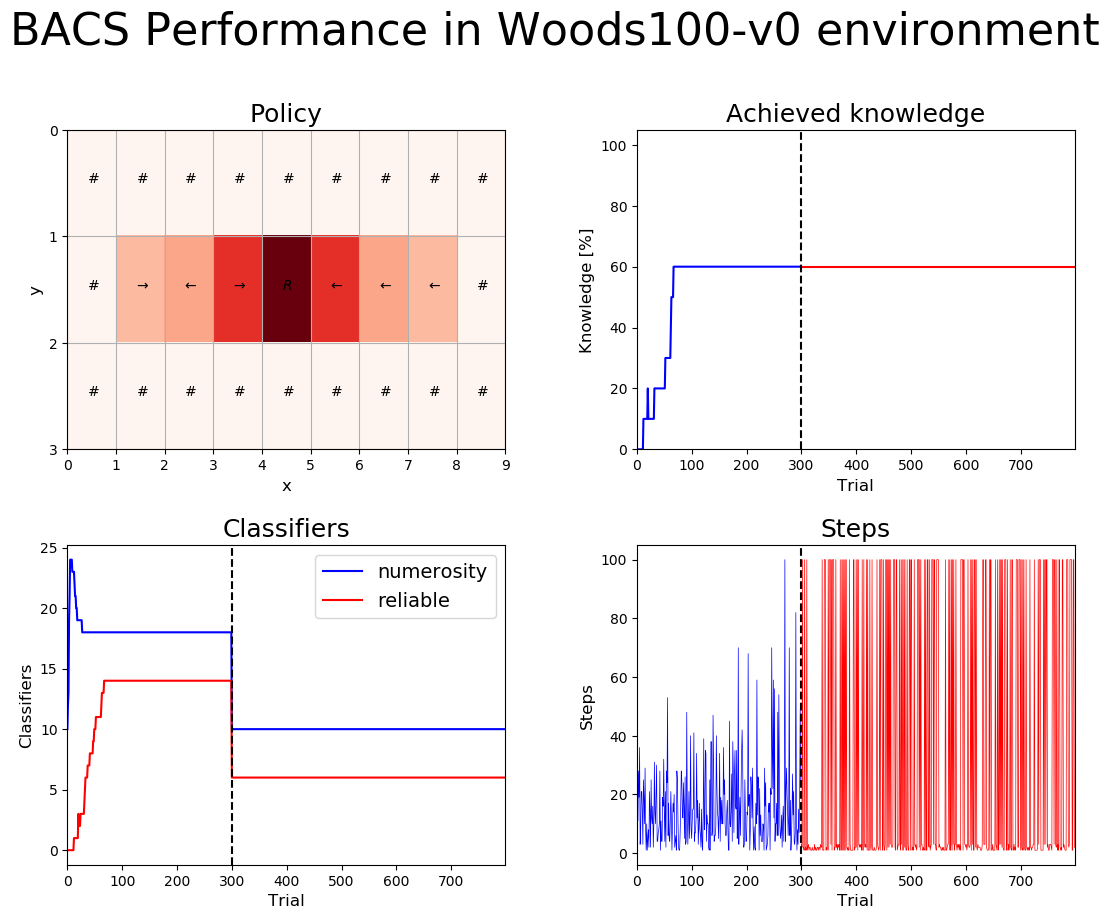

In [7]:
metrics_df = parse_metrics_to_df(metrics_explore, metrics_exploit)
plot_performance(agent_exploit, maze, metrics_df, cfg_exploit, MAZE)

In [8]:
avg_step_explore = 0
for trial in metrics_explore:
    avg_step_explore += trial['steps_in_trial']
avg_step_explore /= NUMBER_OF_EXPLORE_TRIALS
avg_step_exploit = 0
for trial in metrics_exploit:
    avg_step_exploit += trial['steps_in_trial']
avg_step_exploit /= NUMBER_OF_EXPLOIT_TRIALS
print("Average number of steps to solve the maze is ",avg_step_explore,
      " for a total of ", NUMBER_OF_EXPLORE_TRIALS, " trials in EXPLORATION")
print("Average number of steps to solve the maze is ",avg_step_exploit,
      " for a total of ", NUMBER_OF_EXPLOIT_TRIALS, " trials in EXPLOITATION")

Average number of steps to solve the maze is  16.106666666666666  for a total of  300  trials in EXPLORATION
Average number of steps to solve the maze is  33.4  for a total of  500  trials in EXPLOITATION


In [9]:
population_exploit.sort(key=lambda cl: -cl.fitness)
population_exploit_to_display = [cl for cl in population_exploit if cl.does_anticipate_change()]
for cl in population_exploit_to_display:
    print(cl)
    #print("{!r} \t {!r} \t {!r} \t {:.3f} \t {:.3f} \t {:.1f} \t {!r} \t {!r}".format(cl.condition, cl.action, cl.effect, cl.fitness, cl.q, cl.num, cl.exp, cl.mark))
    print("\n")

######9# 6 None None ######0#         (empty)               q: 1.0   r: 999.7  ir: 999.7  f: 999.6  exp: 158 tga: 40    talp: 4831  tav: 38.7   num: 1


##9##### 2 None None ##0#####         (empty)               q: 1.0   r: 999.3  ir: 999.3  f: 999.0  exp: 141 tga: 103   talp: 4758  tav: 34.4   num: 1


##0###0# 6 None None ######9#         (11#111#1)            q: 0.64  r: 740.3  ir: 0.0    f: 473.8  exp: 444 tga: 63    talp: 4830  tav: 13.5   num: 1


######9# 2 None None ######0#         (empty)               q: 1.0   r: 401.2  ir: 0.0    f: 401.2  exp: 155 tga: 69    talp: 4812  tav: 35.5   num: 1


##9##### 6 None None ##0#####         (empty)               q: 1.0   r: 386.6  ir: 0.0    f: 386.5  exp: 134 tga: 79    talp: 4752  tav: 32.9   num: 1


##1##### 6 None None ##0#####         (empty)               q: 1.0   r: 379.3  ir: 0.0    f: 379.3  exp: 363 tga: 39    talp: 4829  tav: 12.2   num: 1


######1# 2 None None ######0#         (empty)               q: 1.0   r: 377.4  ir: